<a href="https://colab.research.google.com/github/Mbigdeli2003/Deep-Learning/blob/main/DNN_HW3_Q3_Morteza_Bigdeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## L2 Regularization

<ipython-input-2-09c804249f54>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-2-09c804249f54>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


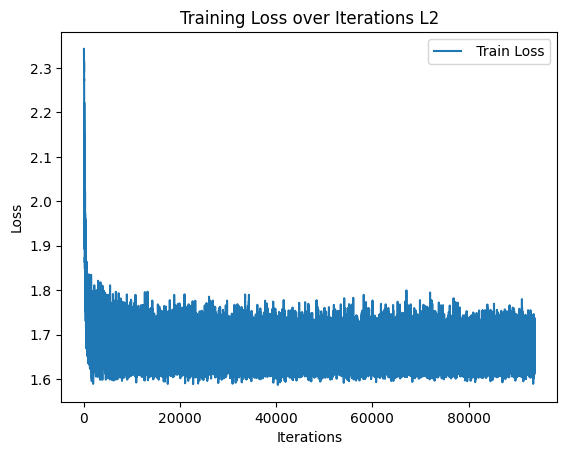

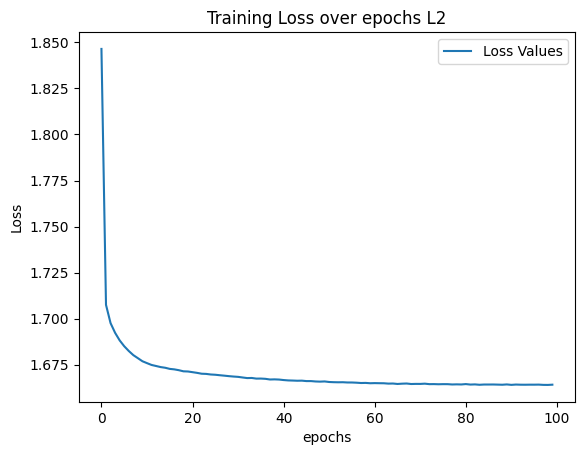

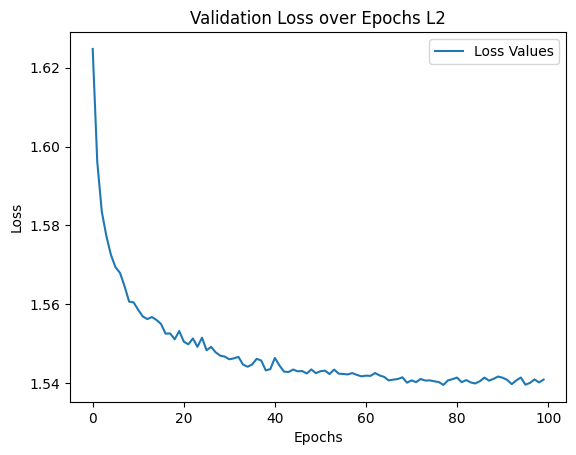

Test Error= 5.840000000000001


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses_l2 = []
    train_loss_epochs_l2=[]
    val_losses_l2 = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_l2.append(loss.item())
            running_loss += loss.item()
        train_loss_epochs_l2.append(running_loss / len(train_loader))



        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_l2.append(running_loss_val / len(test_loader))


    return train_losses_l2, val_losses_l2, train_loss_epochs_l2

# Define different regularization methods
def l2_regularization(model, lambda_l2=0.01):
    l2_norm=0
    l2_norm = (sum(p.pow(2.0).sum() for p in model.parameters()))**(0.5)
    return lambda_l2 * l2_norm

epochs = 100
results = {}

# L2 Regularization
criterion = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets) + l2_regularization(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_l2, val_losses_l2, train_loss_epochs_l2 = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
# Plotting results
plt.plot(train_losses_l2, label=' Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations L2')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_l2, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs L2')
plt.legend()
plt.show()

plt.plot(val_losses_l2, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs L2')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_l2 = (1 - correct / total)*100
print('Test Error=',test_accuracy_l2)

## L2+L1 Regularization

<ipython-input-3-f7a33a862ff5>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-3-f7a33a862ff5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


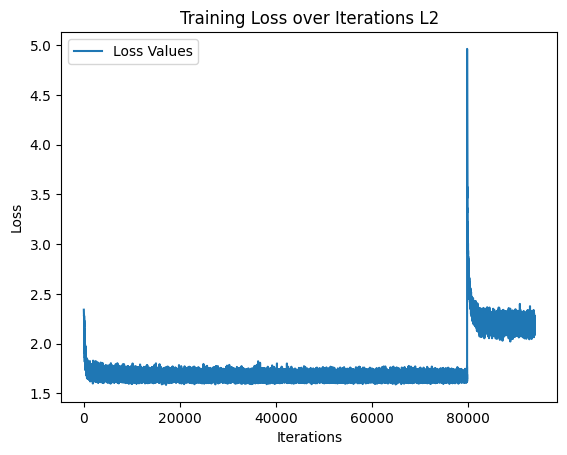

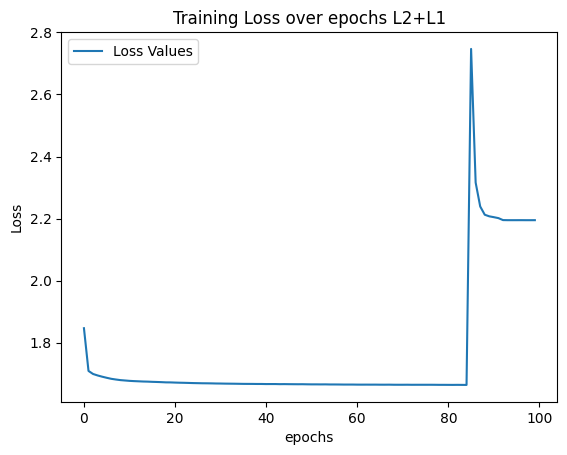

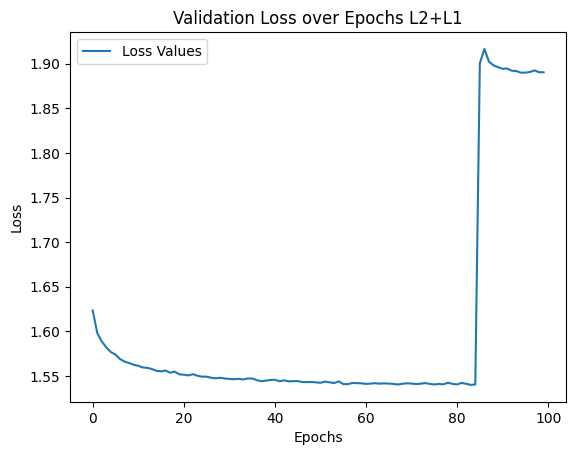

Test Error= 36.91


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion_1, criterion_2, optimizer, epochs):
    train_losses_l2_l1 = []
    train_loss_epochs_l2_l1=[]
    val_losses_l2_l1 = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            if epoch<0.85*epochs:
               loss = criterion_1(outputs, y_batch)
            if epoch>=0.85*epochs:
               loss = criterion_2(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_l2_l1.append(loss.item())
            running_loss += loss.item()
        train_loss_epochs_l2_l1.append(running_loss / len(train_loader))

        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_l2_l1.append(running_loss_val / len(test_loader))


    return train_losses_l2_l1, val_losses_l2_l1, train_loss_epochs_l2_l1

# Define different regularization methods
def l2_regularization(model, lambda_l2=0.01):
    l2_norm =0
    l2_norm = (sum(p.pow(2.0).sum() for p in model.parameters()))**(0.5)
    return lambda_l2 * l2_norm
def l1_regularization(model, lambda_l1=0.01):
    l1_norm=0
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm
epochs = 100
results = {}

# L2+L1 Regularization
criterion_1 = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets) + l2_regularization(model)
criterion_2 = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets) + l1_regularization(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_l2_l1, val_losses_l2_l1, train_loss_epochs_l2_l1 = train_model(model, train_loader, test_loader, criterion_1, criterion_2, optimizer, epochs)
# Plotting results
plt.plot(train_losses_l2_l1, label='Loss Values')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations L2')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_l2_l1, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs L2+L1')
plt.legend()
plt.show()

plt.plot(val_losses_l2_l1, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs L2+L1')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_l2_l1 = (1 - correct / total)*100
print('Test Error=',test_accuracy_l2_l1)



## L2+KL Regularization

<ipython-input-4-206f4f1e1900>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-4-206f4f1e1900>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


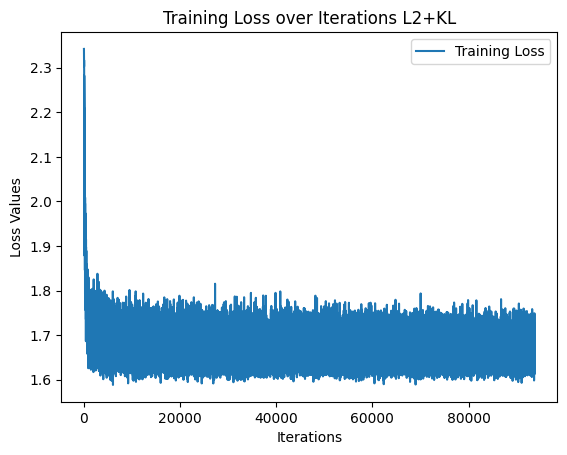

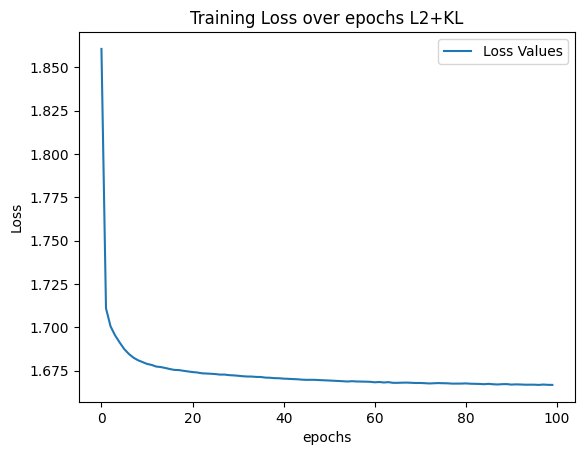

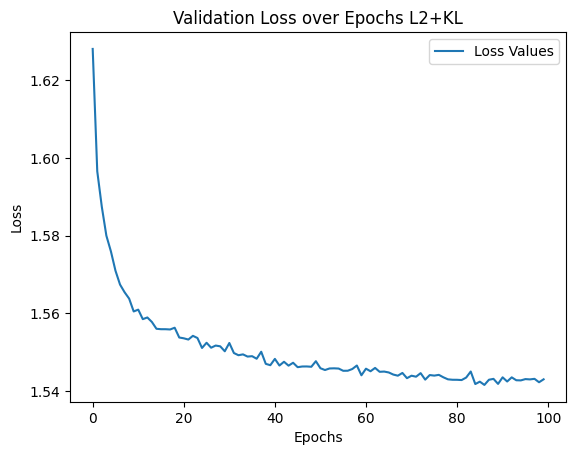

Test Error= 6.140000000000001


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses_l2_kl = []
    train_loss_epochs_l2_kl=[]
    val_losses_l2_kl = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_l2_kl.append(loss.item())
            running_loss += loss.item()
        train_loss_epochs_l2_kl.append(running_loss / len(train_loader))

        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_l2_kl.append(running_loss_val / len(test_loader))


    return train_losses_l2_kl, val_losses_l2_kl, train_loss_epochs_l2_kl

# Define different regularization methods
def l2_regularization(model, lambda_l2=0.01):
    l2_norm =0
    l2_norm = (sum(p.pow(2.0).sum() for p in model.parameters()))**(0.5)
    return lambda_l2 * l2_norm

def kl_sparsity_regularization(model, rho=0.05, beta=0.01):
    kl_div = 0.0
    for layer in model:
        if isinstance(layer, nn.Linear):
            p = torch.mean(torch.abs(layer.weight))
            kl_div += beta * (rho * torch.log(rho / p) + (1 - rho) * torch.log((1 - rho) / (1 - p)))
    return kl_div

epochs = 100
results = {}

# L2 Regularization
criterion = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets) + l2_regularization(model)+kl_sparsity_regularization(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_l2_kl, val_losses_l2_kl, train_loss_epochs_l2_kl = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
# Plotting results
plt.plot(train_losses_l2_kl, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss Values')
plt.title('Training Loss over Iterations L2+KL')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_l2_kl, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs L2+KL')
plt.legend()
plt.show()

plt.plot(val_losses_l2_kl, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs L2+KL')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_l2_kl = (1 - correct / total)*100
print('Test Error=',test_accuracy_l2_kl)


## Max-Norm Regularization

<ipython-input-5-1309f49291c8>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-5-1309f49291c8>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


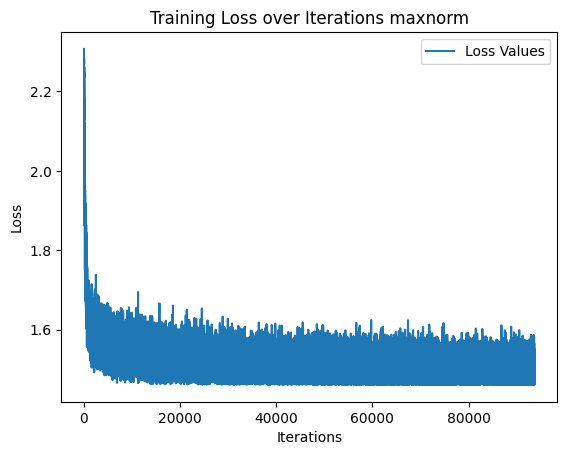

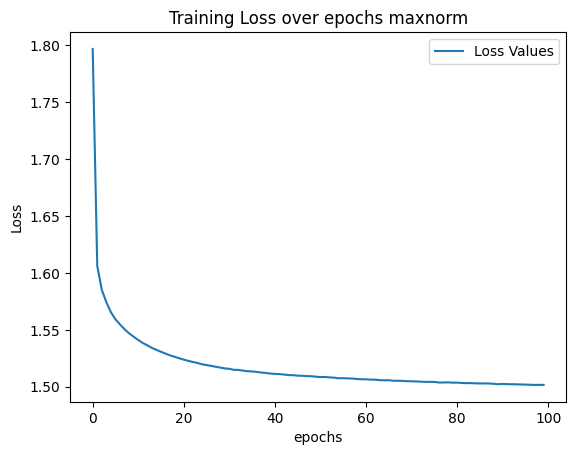

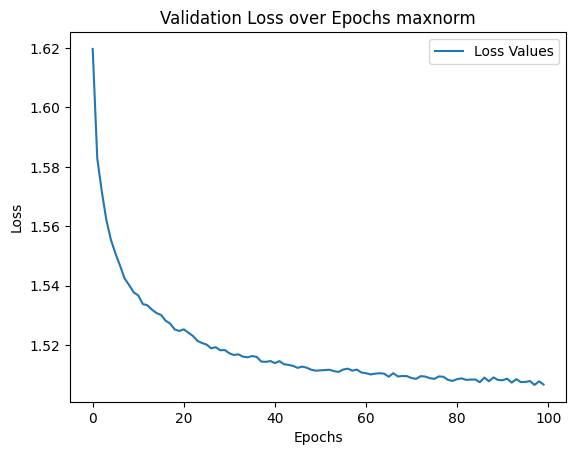

Test Error= 4.479999999999995


In [ ]:
# Max-Norm Regularization
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses_maxnorm = []
    train_loss_epochs_maxnorm=[]
    val_losses_maxnorm = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_maxnorm.append(loss.item())
            running_loss += loss.item()
            max_norm_regularization(model)
        train_loss_epochs_maxnorm.append(running_loss / len(train_loader))

        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_maxnorm.append(running_loss_val / len(test_loader))


    return train_losses_maxnorm, val_losses_maxnorm, train_loss_epochs_maxnorm

# Define different regularization methods
def max_norm_regularization(model, max_norm=3):
    for layer in model:
        if isinstance(layer, nn.Linear):
            layer.weight.data = torch.clamp(layer.weight.data, -max_norm, max_norm)

epochs = 100
results = {}

# L2 Regularization
criterion = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_maxnorm, val_losses_maxnorm, train_loss_epochs_maxnorm = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
# Plotting results
plt.plot(train_losses_maxnorm, label='Loss Values')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations maxnorm')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_maxnorm, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs maxnorm')
plt.legend()
plt.show()

plt.plot(val_losses_maxnorm, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs maxnorm')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_maxnorm = (1 - correct / total)*100
print('Test Error=',test_accuracy_maxnorm)


## Droput+L2 Regularization

<ipython-input-6-f8f88bc4e797>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-6-f8f88bc4e797>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


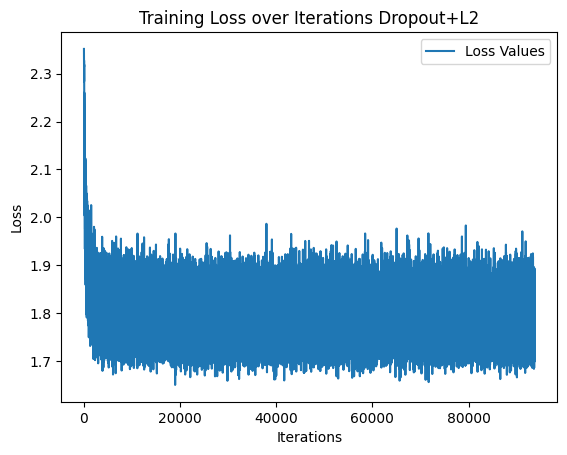

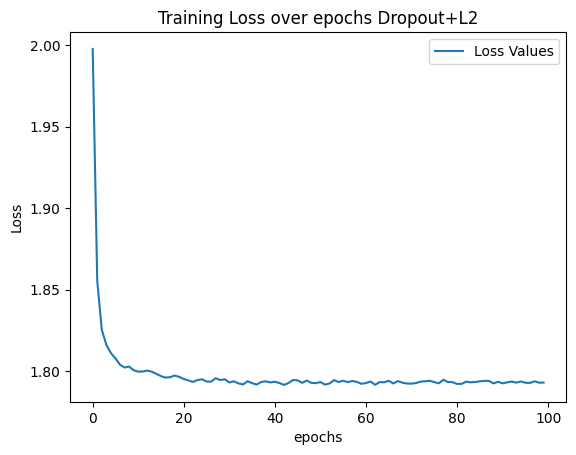

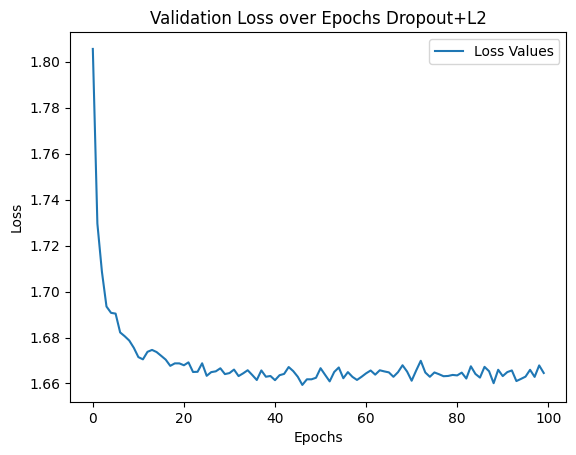

Test Error= 10.319999999999997


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses_D_l2 = []
    train_loss_epochs_D_l2=[]
    val_losses_D_l2 = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_D_l2.append(loss.item())
            running_loss += loss.item()
        train_loss_epochs_D_l2.append(running_loss / len(train_loader))



        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_D_l2.append(running_loss_val / len(test_loader))


    return train_losses_D_l2, val_losses_D_l2, train_loss_epochs_D_l2

# Define different regularization methods
def l2_regularization(model, lambda_l2=0.01):
    l2_norm=0
    l2_norm = (sum(p.pow(2.0).sum() for p in model.parameters()))**(0.5)
    return lambda_l2 * l2_norm

epochs = 100
results = {}

# L2 Regularization
criterion = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets) + l2_regularization(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_D_l2, val_losses_D_l2, train_loss_epochs_D_l2 = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
# Plotting results
plt.plot(train_losses_D_l2, label='Loss Values')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations Dropout+L2')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_D_l2, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs Dropout+L2')
plt.legend()
plt.show()

plt.plot(val_losses_D_l2, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs Dropout+L2')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_D_l2 = (1 - correct / total)*100
print('Test Error=',test_accuracy_D_l2)

## Droput+maxnorm

<ipython-input-7-96d6239519b1>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-7-96d6239519b1>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


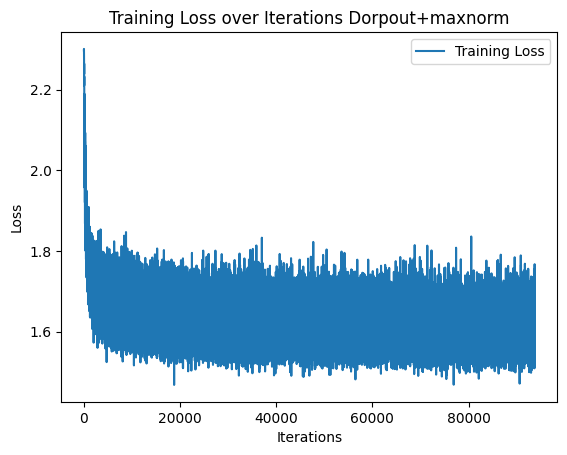

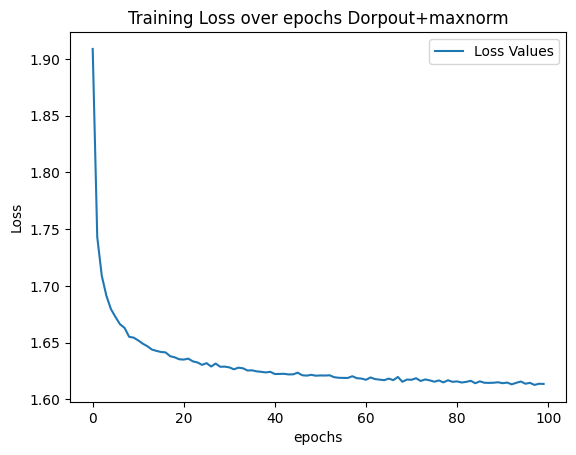

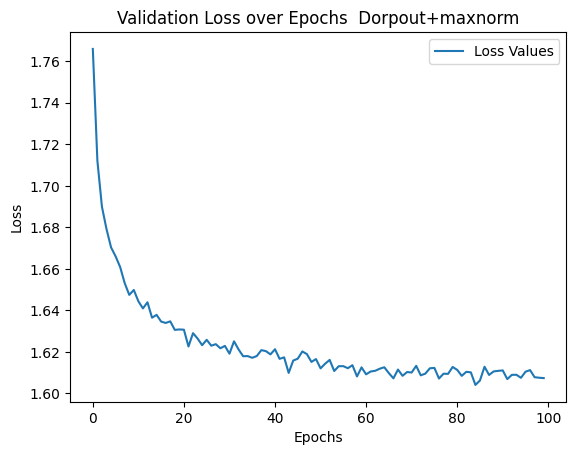

Test Error= 8.230000000000004


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
# Downsample to 7x7
X_train= F.avg_pool2d(X_train, kernel_size=4, stride=4)
X_test = F.avg_pool2d(X_test, kernel_size=4, stride=4)

# Normalize and reshape
mean = torch.mean(X_train)
std = torch.std(X_train)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_train = X_train.reshape(-1, 7*7)
X_test = X_test.reshape(-1, 7*7)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define MLP model
input_features = 7*7
output_features = 10
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, output_features),
    nn.Softmax(dim=1)
)

# Define training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses_D_maxnorm = []
    train_loss_epochs_D_maxnorm=[]
    val_losses_D_maxnorm = []
    criterion_val = nn.CrossEntropyLoss()
    optimizer_val = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_D_maxnorm.append(loss.item())
            running_loss += loss.item()
            max_norm_regularization(model)
        train_loss_epochs_D_maxnorm.append(running_loss / len(train_loader))

        with torch.no_grad():
             running_loss_val = 0.0
             for X_batch, y_batch in test_loader:
                 outputs_val = model(X_batch)
                 val_loss = criterion_val(outputs_val.squeeze(), y_batch)
                 running_loss_val += val_loss.item()
        val_losses_D_maxnorm.append(running_loss_val / len(test_loader))


    return train_losses_D_maxnorm, val_losses_D_maxnorm, train_loss_epochs_D_maxnorm

# Define different regularization methods
def max_norm_regularization(model, max_norm=3):
    for layer in model:
        if isinstance(layer, nn.Linear):
            layer.weight.data = torch.clamp(layer.weight.data, -max_norm, max_norm)

epochs = 100
results = {}

# L2 Regularization
criterion = lambda outputs, targets: nn.CrossEntropyLoss()(outputs, targets)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_D_maxnorm, val_losses_D_maxnorm, train_loss_epochs_D_maxnorm = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
# Plotting results
plt.plot(train_losses_D_maxnorm, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations Dorpout+maxnorm')
plt.legend()
plt.show()

plt.plot(train_loss_epochs_D_maxnorm, label='Loss Values')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs Dorpout+maxnorm')
plt.legend()
plt.show()

plt.plot(val_losses_D_maxnorm, label='Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs  Dorpout+maxnorm')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
           outputs = model(X_test.view(X_test.size(0), -1))
           _, predicted = torch.max(outputs.data, 1)
           total += y_test.size(0)
           correct += (predicted == y_test).sum().item()

test_accuracy_D_maxnorm = (1 - correct / total)*100
print('Test Error=',test_accuracy_D_maxnorm)

## plotting all results for comparing

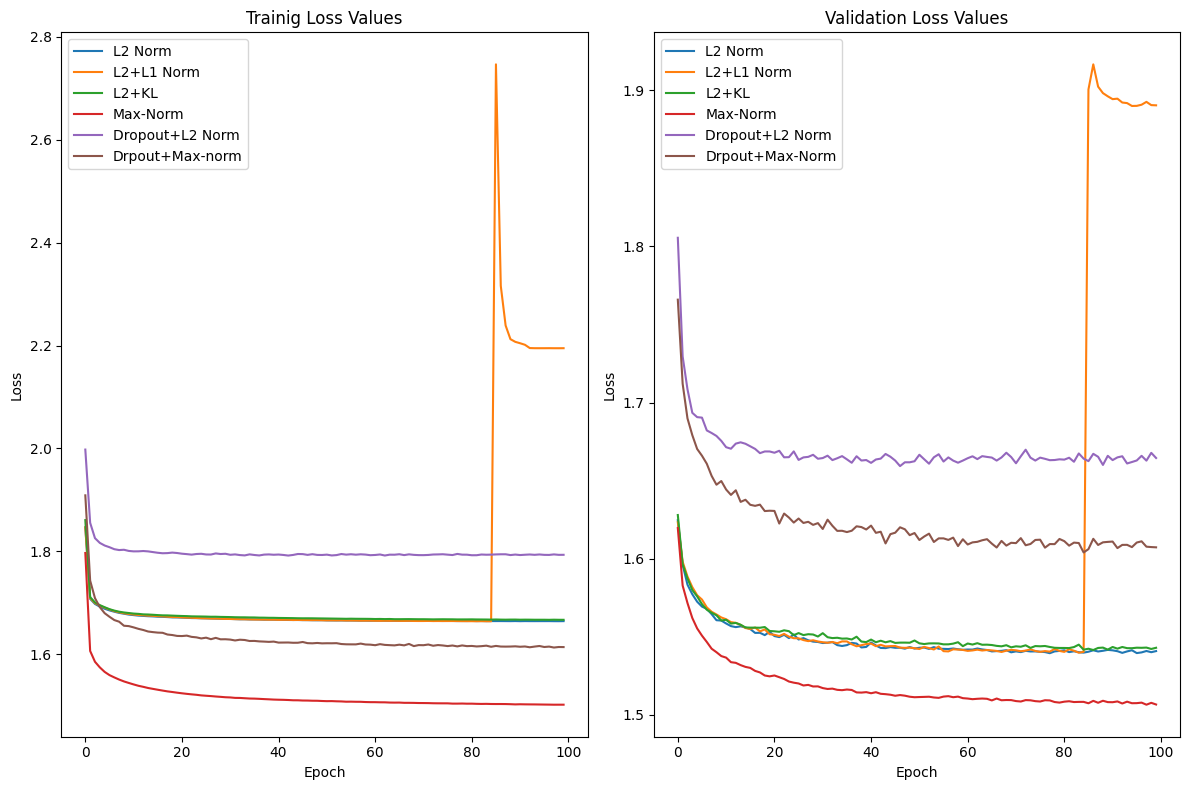

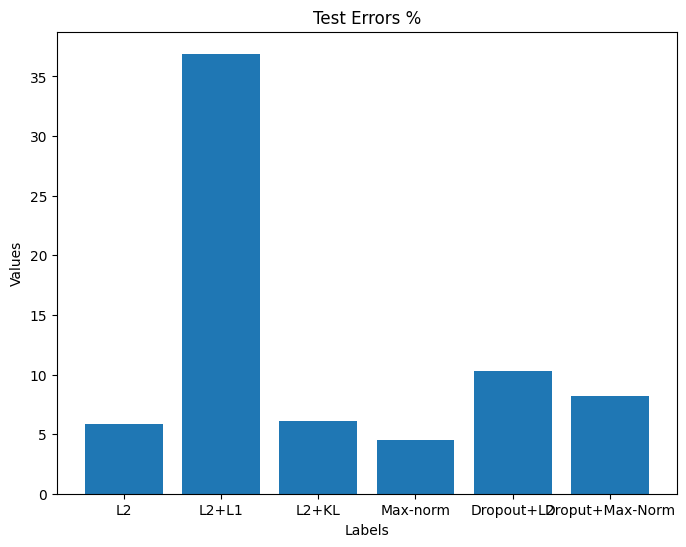

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.plot(train_loss_epochs_l2, label='L2 Norm')
plt.plot(train_loss_epochs_l2_l1, label='L2+L1 Norm')
plt.plot(train_loss_epochs_l2_kl, label='L2+KL ')
plt.plot(train_loss_epochs_maxnorm, label='Max-Norm')
plt.plot(train_loss_epochs_D_l2, label='Dropout+L2 Norm')
plt.plot(train_loss_epochs_D_maxnorm, label='Drpout+Max-norm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trainig Loss Values')
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_losses_l2, label='L2 Norm')
plt.plot(val_losses_l2_l1, label='L2+L1 Norm')
plt.plot(val_losses_l2_kl, label='L2+KL')
plt.plot(val_losses_maxnorm, label='Max-Norm')
plt.plot(val_losses_D_l2, label='Dropout+L2 Norm')
plt.plot(val_losses_D_maxnorm, label='Drpout+Max-Norm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Values')
plt.legend()

plt.tight_layout()
plt.show()

Test_error_values=[test_accuracy_l2, test_accuracy_l2_l1, test_accuracy_l2_kl, test_accuracy_maxnorm, test_accuracy_D_l2, test_accuracy_D_maxnorm]
labels = ['L2', 'L2+L1', 'L2+KL', 'Max-norm', 'Dropout+L2', 'Droput+Max-Norm']

plt.figure(figsize=(8, 6))
plt.bar(labels, Test_error_values)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Test Errors %')
plt.show()